In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import platform
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.core.nanops import bottleneck_switch

from Detector_Classes.M3RefTracking import M3RefTracking
from Detector_Classes.DetectorConfigLoader import DetectorConfigLoader
from Detector_Classes.DreamDetector import DreamDetector

from det_classes_test import plot_ray_hits_2d, align_dream, get_residuals, get_efficiency, get_efficiency_1d, get_residuals_subdets_with_err, get_rays_in_sub_det_vectorized, get_rays_in_sub_det, get_raw_residuals, get_circle_scan, plot_2D_circle_scan

In [3]:
# Check if platform is Windows or Linux
if platform.system() == 'Windows':
    base_dir = 'F:/Saclay/cosmic_data/'
    det_type_info_dir = 'C:/Users/Dylan/PycharmProjects/Cosmic_Bench_DAQ_Control/config/detectors/'
    out_dir = 'F:/Saclay/Analysis/Cosmic Bench/11-5-24/'
    chunk_size = 5  # Number of files to process at once
elif platform.system() == 'Linux' and platform.node() == 'dylan-MS-7C84':
    base_dir = '/media/ucla/Saclay/cosmic_data/'
    det_type_info_dir = '/home/dylan/PycharmProjects/Cosmic_Bench_DAQ_Control/config/detectors/'
    out_dir = '/media/ucla/Saclay/Analysis/Cosmic Bench/11-5-24/'
    chunk_size = 5  # Number of files to process at once
elif platform.system() == 'Linux' and platform.node() == 'dphnpct50.extra.cea.fr':
    base_dir = '/local/home/dn277127/Bureau/cosmic_data/'
    det_type_info_dir = '/local/home/dn277127/PycharmProjects/Cosmic_Bench_DAQ_Control/config/detectors/'
    out_dir = '/local/home/dn277127/Bureau/cosmic_data/Analysis/11-15-24/'
    chunk_size = 0.2  # Number of files to process at once
else:
    raise OSError('Unknown platform')

run_name = 'beam_test_fe_zs_test_10-10-25'
run_dir = f'{base_dir}{run_name}/'
sub_run_name = 'quick_test_440V'

det_single = 'rd542_plein_3'

# file_nums = list(range(0, 3))
# file_nums = list(range(0, 109))
file_nums = 'all'

noise_sigma = 4

# realign_dream = True  # If False, read alignment from file, if True, realign Dream detector
realign_dream = False  # If False, read alignment from file, if True, realign Dream detector

run_json_path = f'{run_dir}run_config.json'
data_dir = f'{run_dir}{sub_run_name}/filtered_root/'
ped_dir = f'{run_dir}{sub_run_name}/decoded_root/'
m3_dir = f'{run_dir}{sub_run_name}/m3_tracking_root/'
alignment_dir = f'{run_dir}alignments/'

z_align_range = [15, 15]  # mm range to search for optimal z position
z_rot_align_range = [-2, 2]

try:
    os.mkdir(alignment_dir)
except FileExistsError:
    pass
try:
    os.mkdir(out_dir)
except FileExistsError:
    pass

In [4]:
det_config_loader = DetectorConfigLoader(run_json_path, det_type_info_dir)

In [5]:
det_config = det_config_loader.get_det_config(det_single, sub_run_name=sub_run_name)
det = DreamDetector(config=det_config)
print(f'FEU Num: {det.feu_num}')
print(f'FEU Channels: {det.feu_connectors}')
print(f'HV: {det.hv}')

det.load_dream_data(data_dir, ped_dir, noise_sigma, file_nums, chunk_size, hist_raw_amps=True, save_waveforms=False, waveform_fit_func='parabola_vectorized')
print(f'Hits shape: {det.dream_data.hits.shape}')

Found 2 groups in detector map
FEU Num: 1
FEU Channels: [1, 2, 3, 4]
HV: {'drift': 800, 'resist_1': 300, 'resist_2': 440}
Reading in data...


100%|██████████| 1/1 [00:15<00:00, 15.01s/it]


Read in data shape: (32479, 256, 32)
Getting amplitudes...


100%|██████████| 15/15 [00:00<00:00, 27.69it/s]


Fitting time: 0.6930725574493408 s
Processed sub-chunk 1/1
Processed chunk 1/1
Getting hits...
Hits shape: (32479, 256)


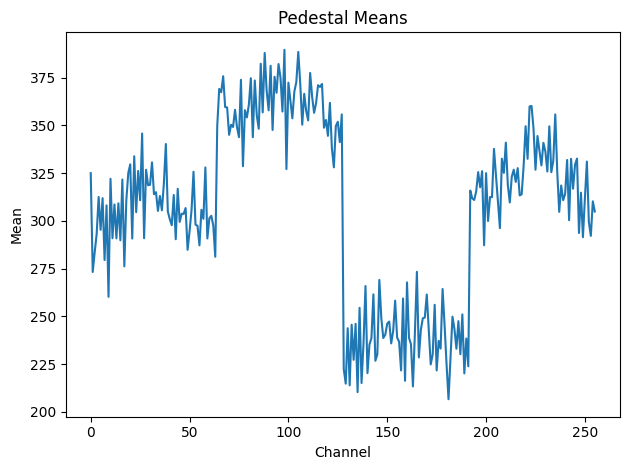

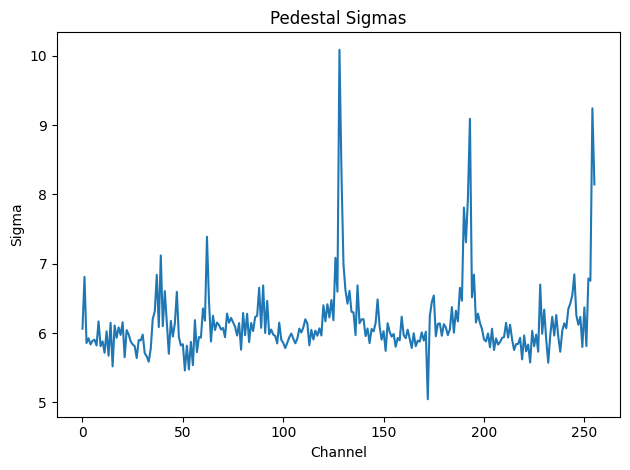

In [6]:
det.dream_data.plot_pedestals()

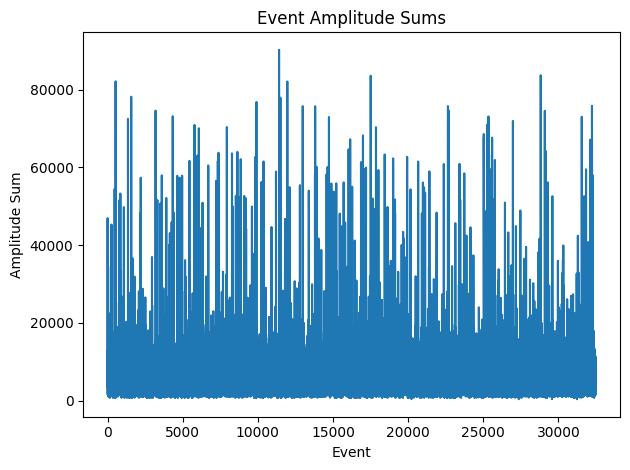

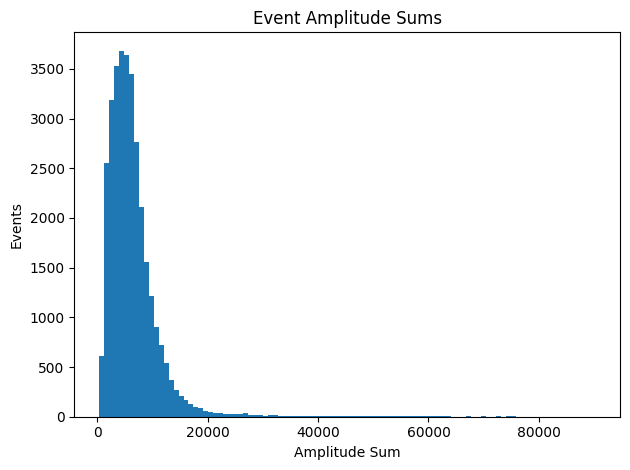

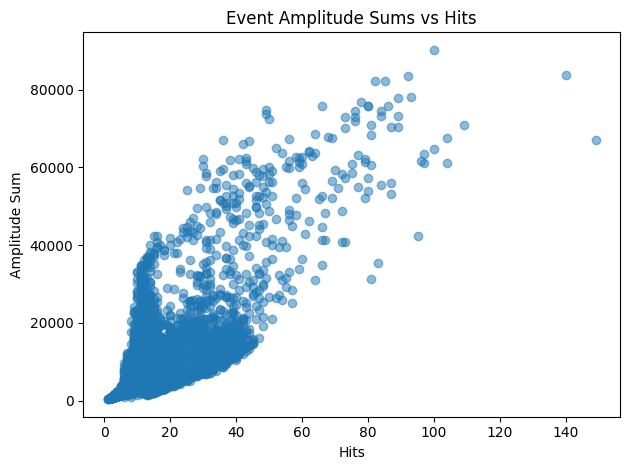

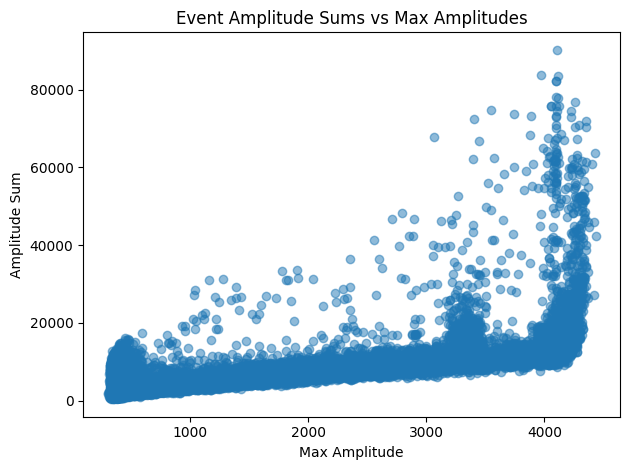

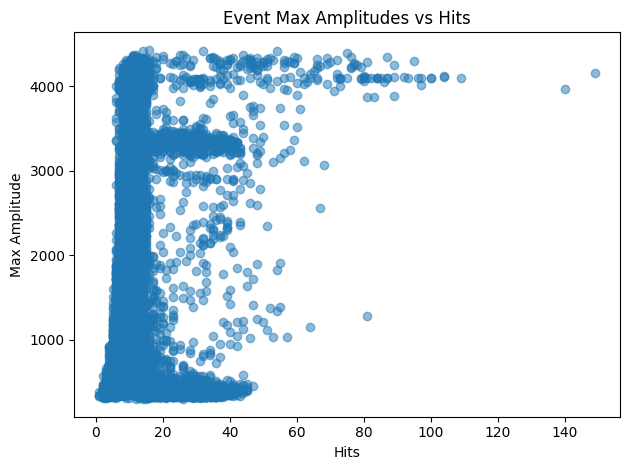

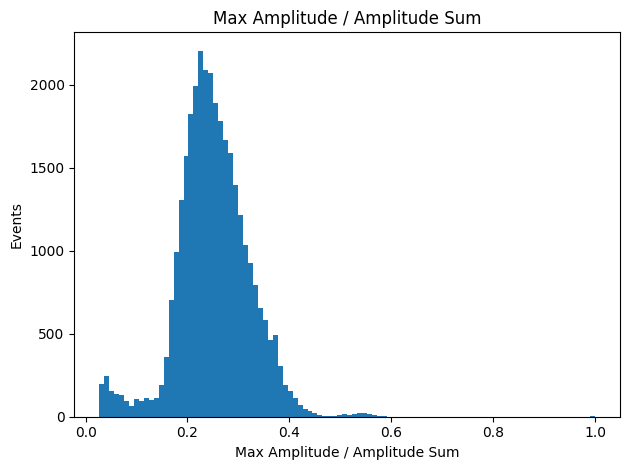

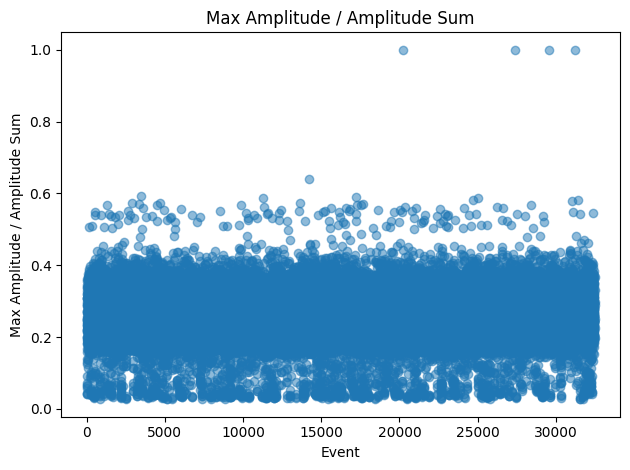

In [7]:
det.dream_data.plot_noise_metric()

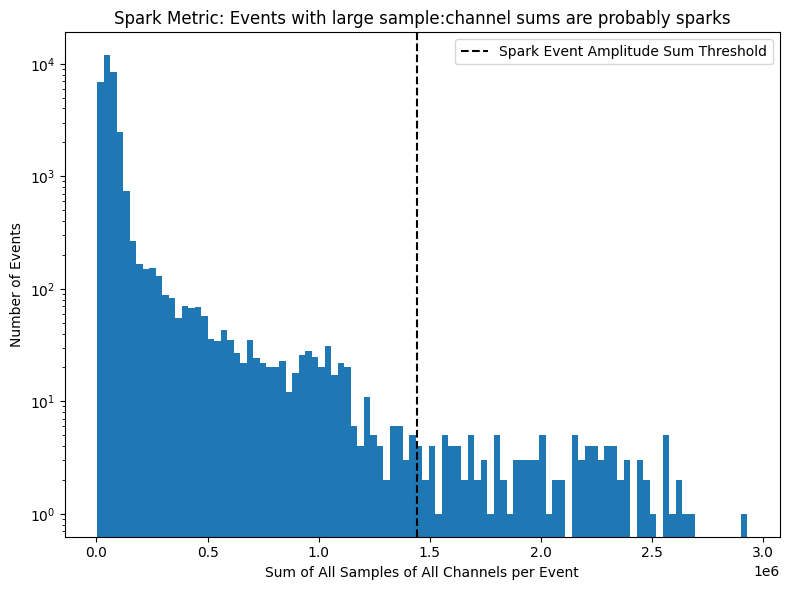

In [8]:
det.dream_data.filter_sparks(spark_filter_sigma=8)

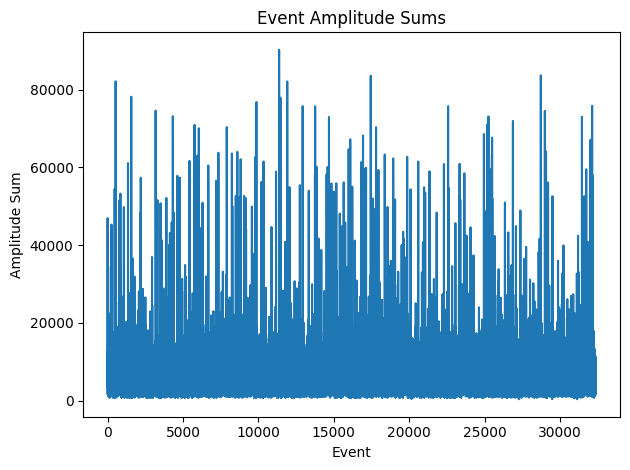

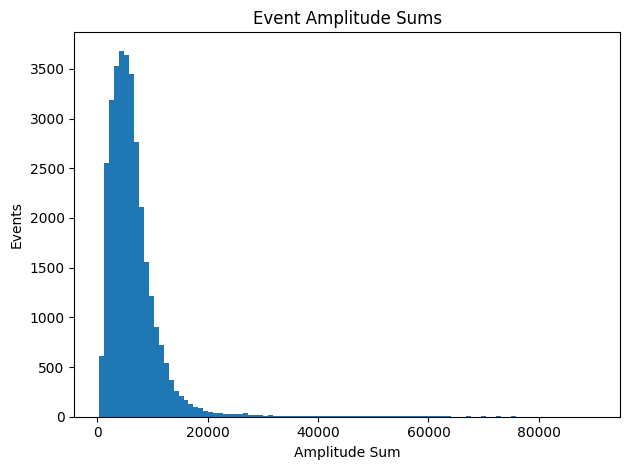

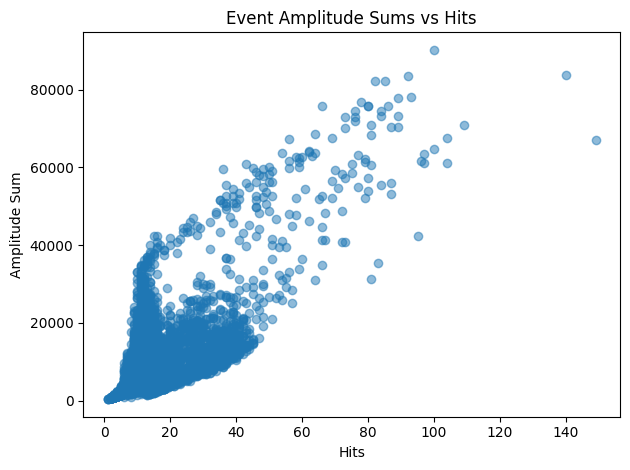

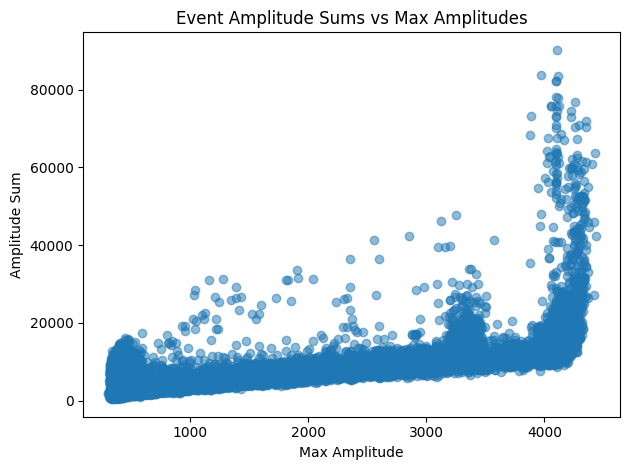

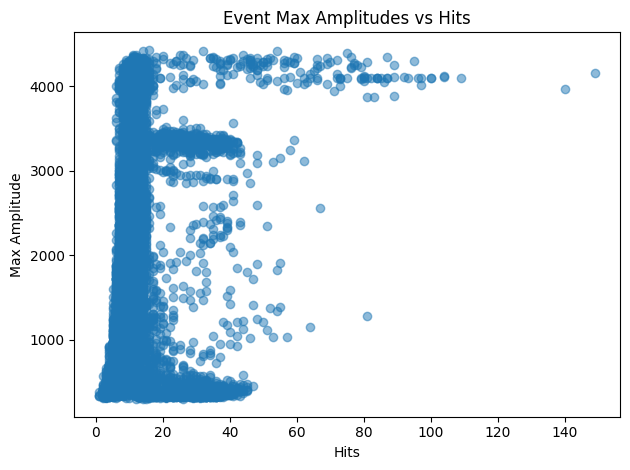

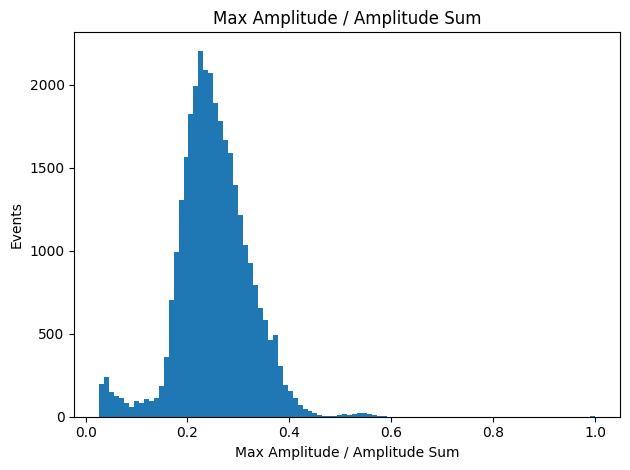

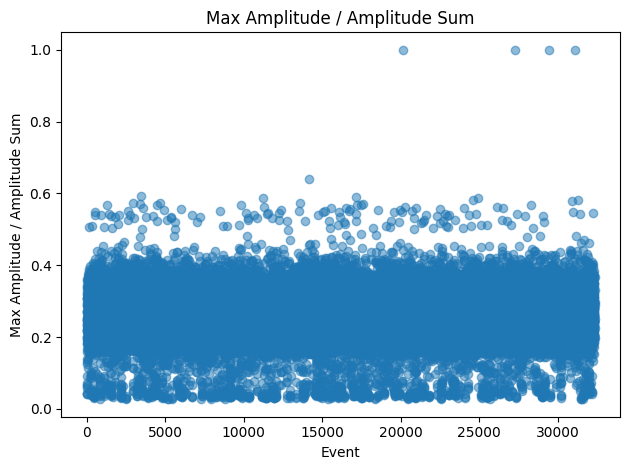

In [9]:
det.dream_data.plot_noise_metric()

Connector 1 Dead Strips: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 38 40 42 43 44 45 46 48 49 50 57 58 59 60 61
 62 63]
Connector 2 Dead Strips: [64]
Connector 3 Dead Strips: [128 130]
Connector 4 Dead Strips: [251 252 254 255]


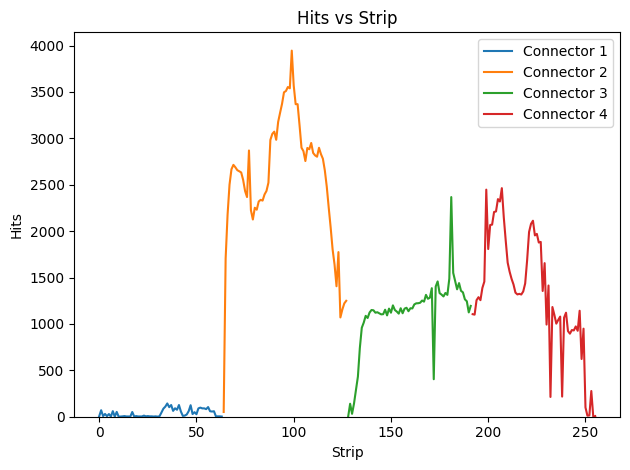

In [10]:
det.dream_data.plot_hits_vs_strip(print_dead_strips=True)

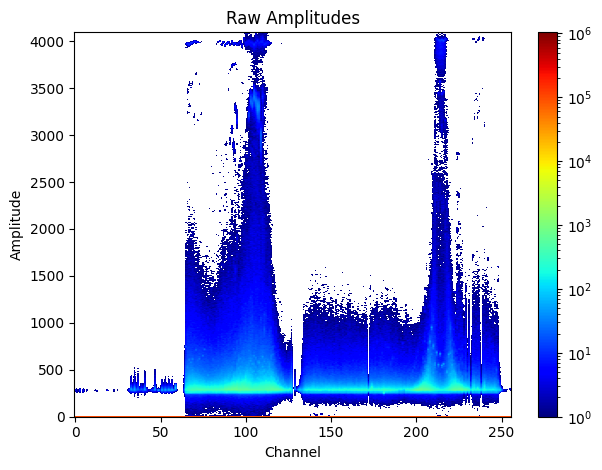

In [11]:
det.dream_data.plot_raw_amps_2d_hist()

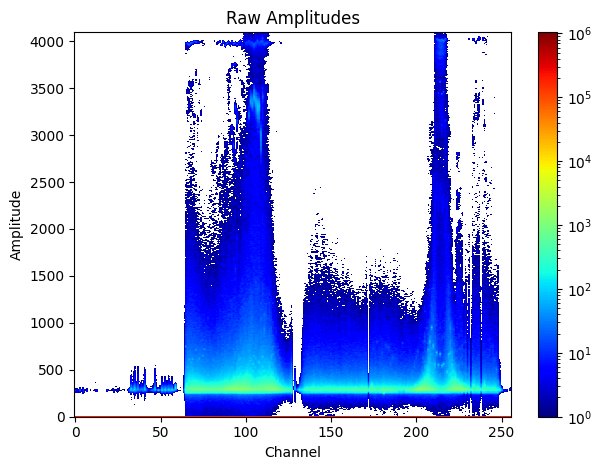

In [12]:
det.dream_data.plot_raw_amps_2d_hist(combine_y=2)

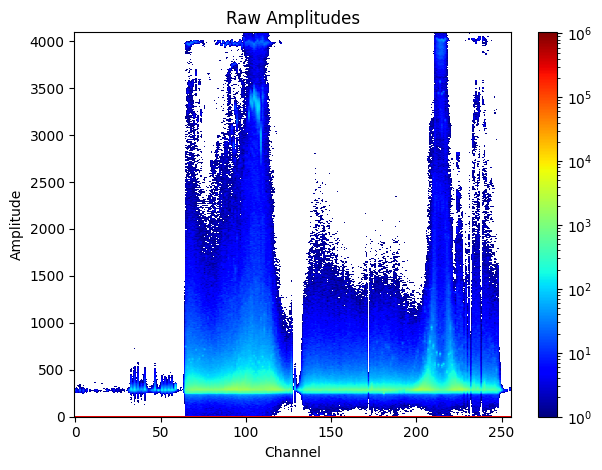

In [13]:
det.dream_data.plot_raw_amps_2d_hist(combine_y=3)

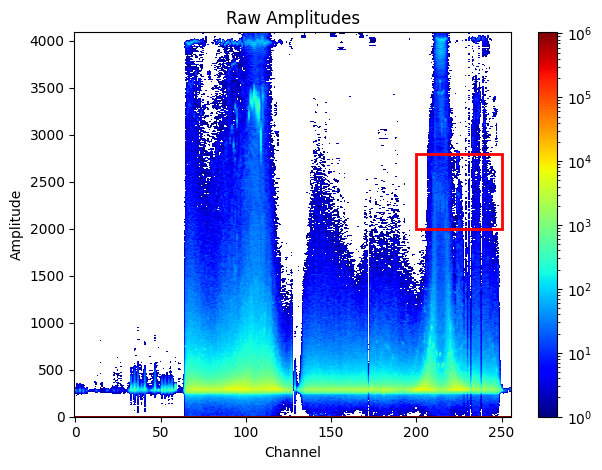

In [14]:
channel_range = (200, 250)
amplitude_range = (2000, 2800)
det.dream_data.plot_raw_amps_2d_hist(combine_y=10)

# Add a rectangle around channel/amplitude range
rect = plt.Rectangle((channel_range[0], amplitude_range[0]), channel_range[-1] - channel_range[0], amplitude_range[-1] - amplitude_range[0], fill=False, color='red', linewidth=2)
plt.gca().add_patch(rect)

In [15]:
det.make_sub_detectors()

8285184
8285184


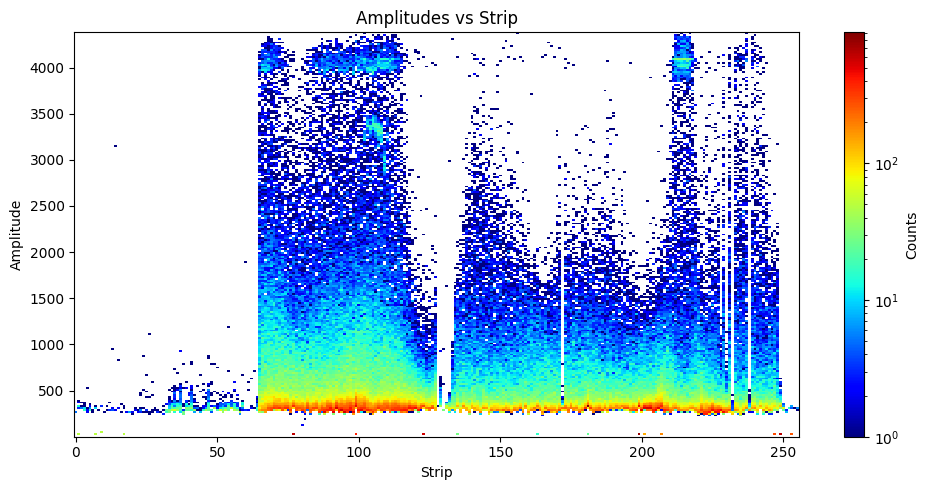

In [16]:
det.dream_data.plot_amplitudes_vs_strip()

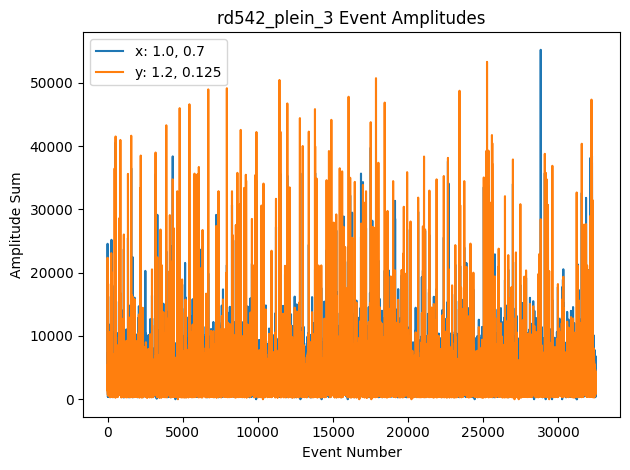

In [17]:
# det.make_sub_detectors()
event_nums = det.plot_xy_amp_sum_vs_event_num(True, 500, False, 15)

# if realign_dream:
#     det.center[2] = 722
#     det.add_rotation(90, 'z')

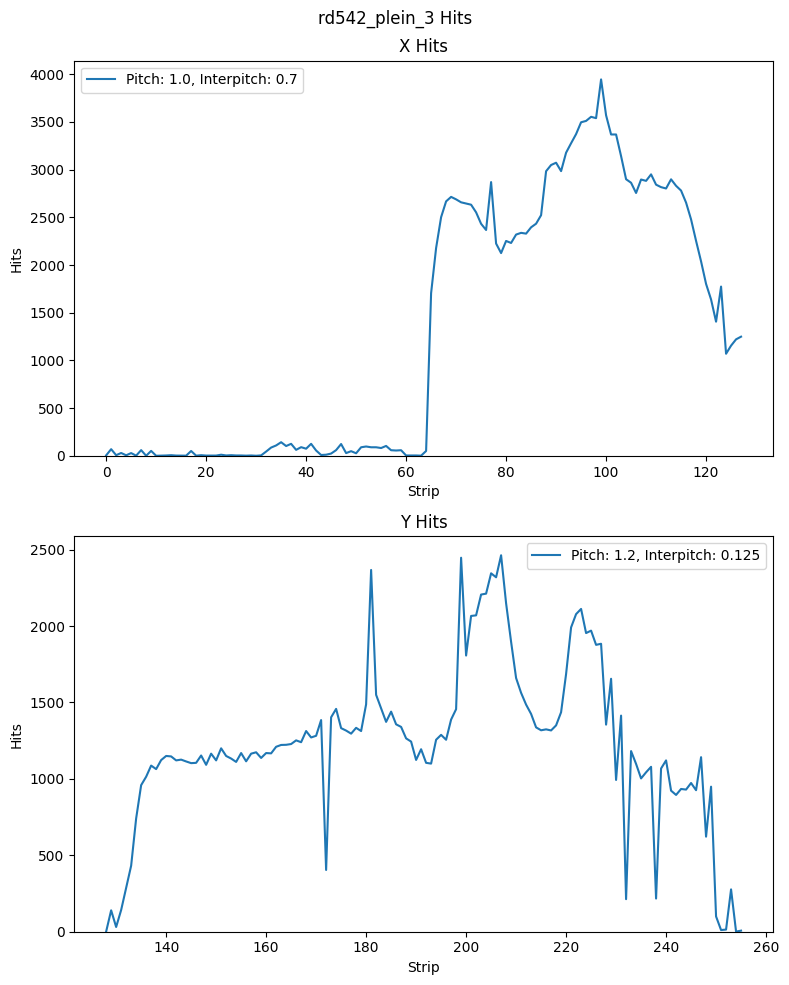

In [18]:
det.plot_hits_1d()

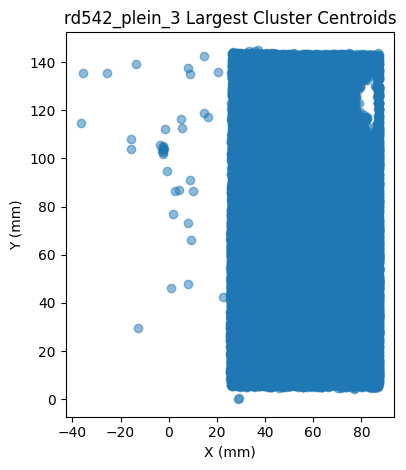

In [19]:
det.plot_centroids_2d()

In [20]:
det.get_det_clusters()

Text(0.5, 1.0, 'Time of Max for Y (Bottom) Strips')

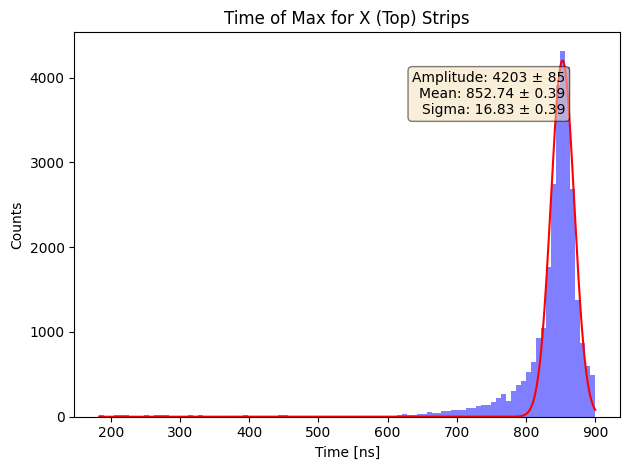

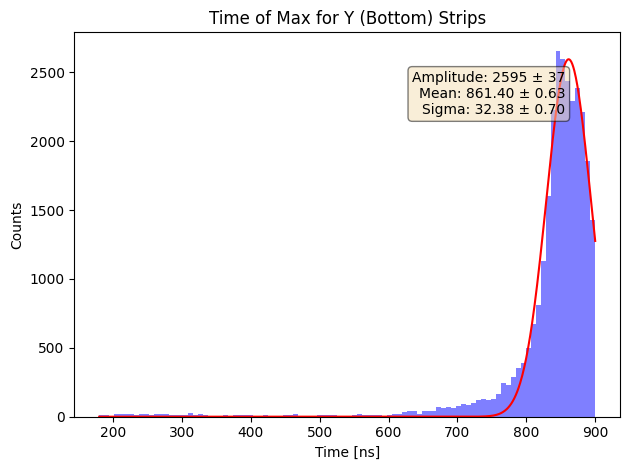

In [21]:
det.dream_data.correct_for_fine_timestamps()

sigma_x, sigma_x_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(0, int(256 / 2)), min_amp=None, plot=True)
plt.title(f'Time of Max for X (Top) Strips')

sigma_y, sigma_y_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(int(256 / 2), 256), min_amp=None, plot=True)
plt.title(f'Time of Max for Y (Bottom) Strips')

Text(0.5, 1.0, 'Time of Max for Y (Bottom) Strips Min Amp 600')

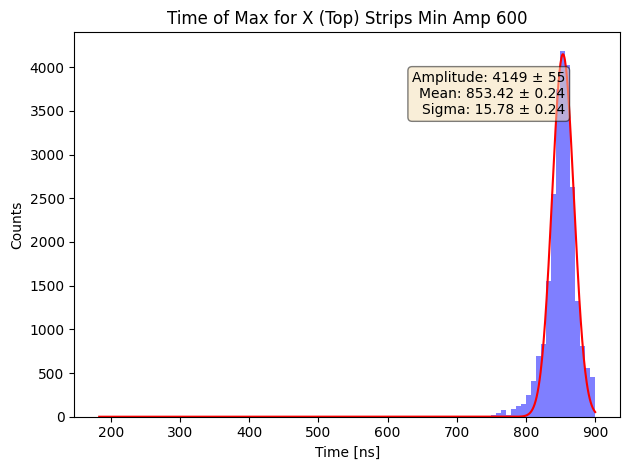

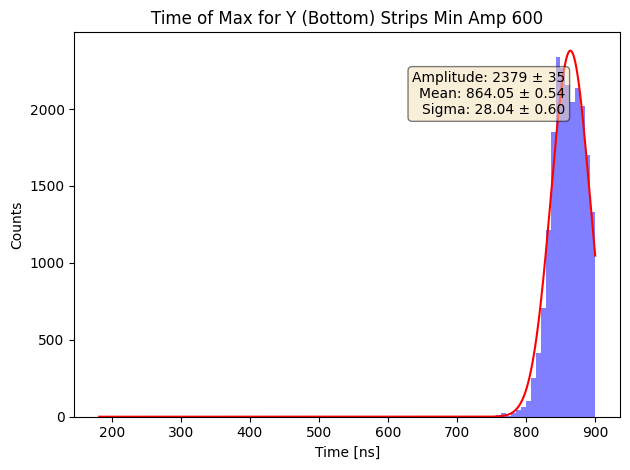

In [22]:
min_amp = 600
sigma_x, sigma_x_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(0, int(256 / 2)), min_amp=min_amp, plot=True)
plt.title(f'Time of Max for X (Top) Strips Min Amp {min_amp}')

sigma_y, sigma_y_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(int(256 / 2), 256), min_amp=min_amp, plot=True)
plt.title(f'Time of Max for Y (Bottom) Strips Min Amp {min_amp}')